<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

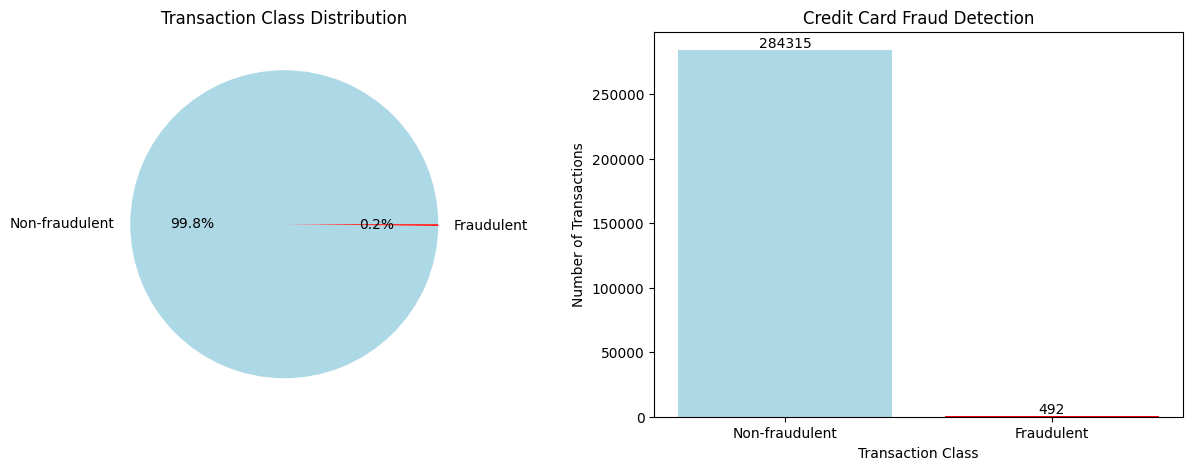

Number of normal transactions = 284315 (% 99.82725143693798)
Number of fraudulent transactions = 492 (% 0.1727485630620034)


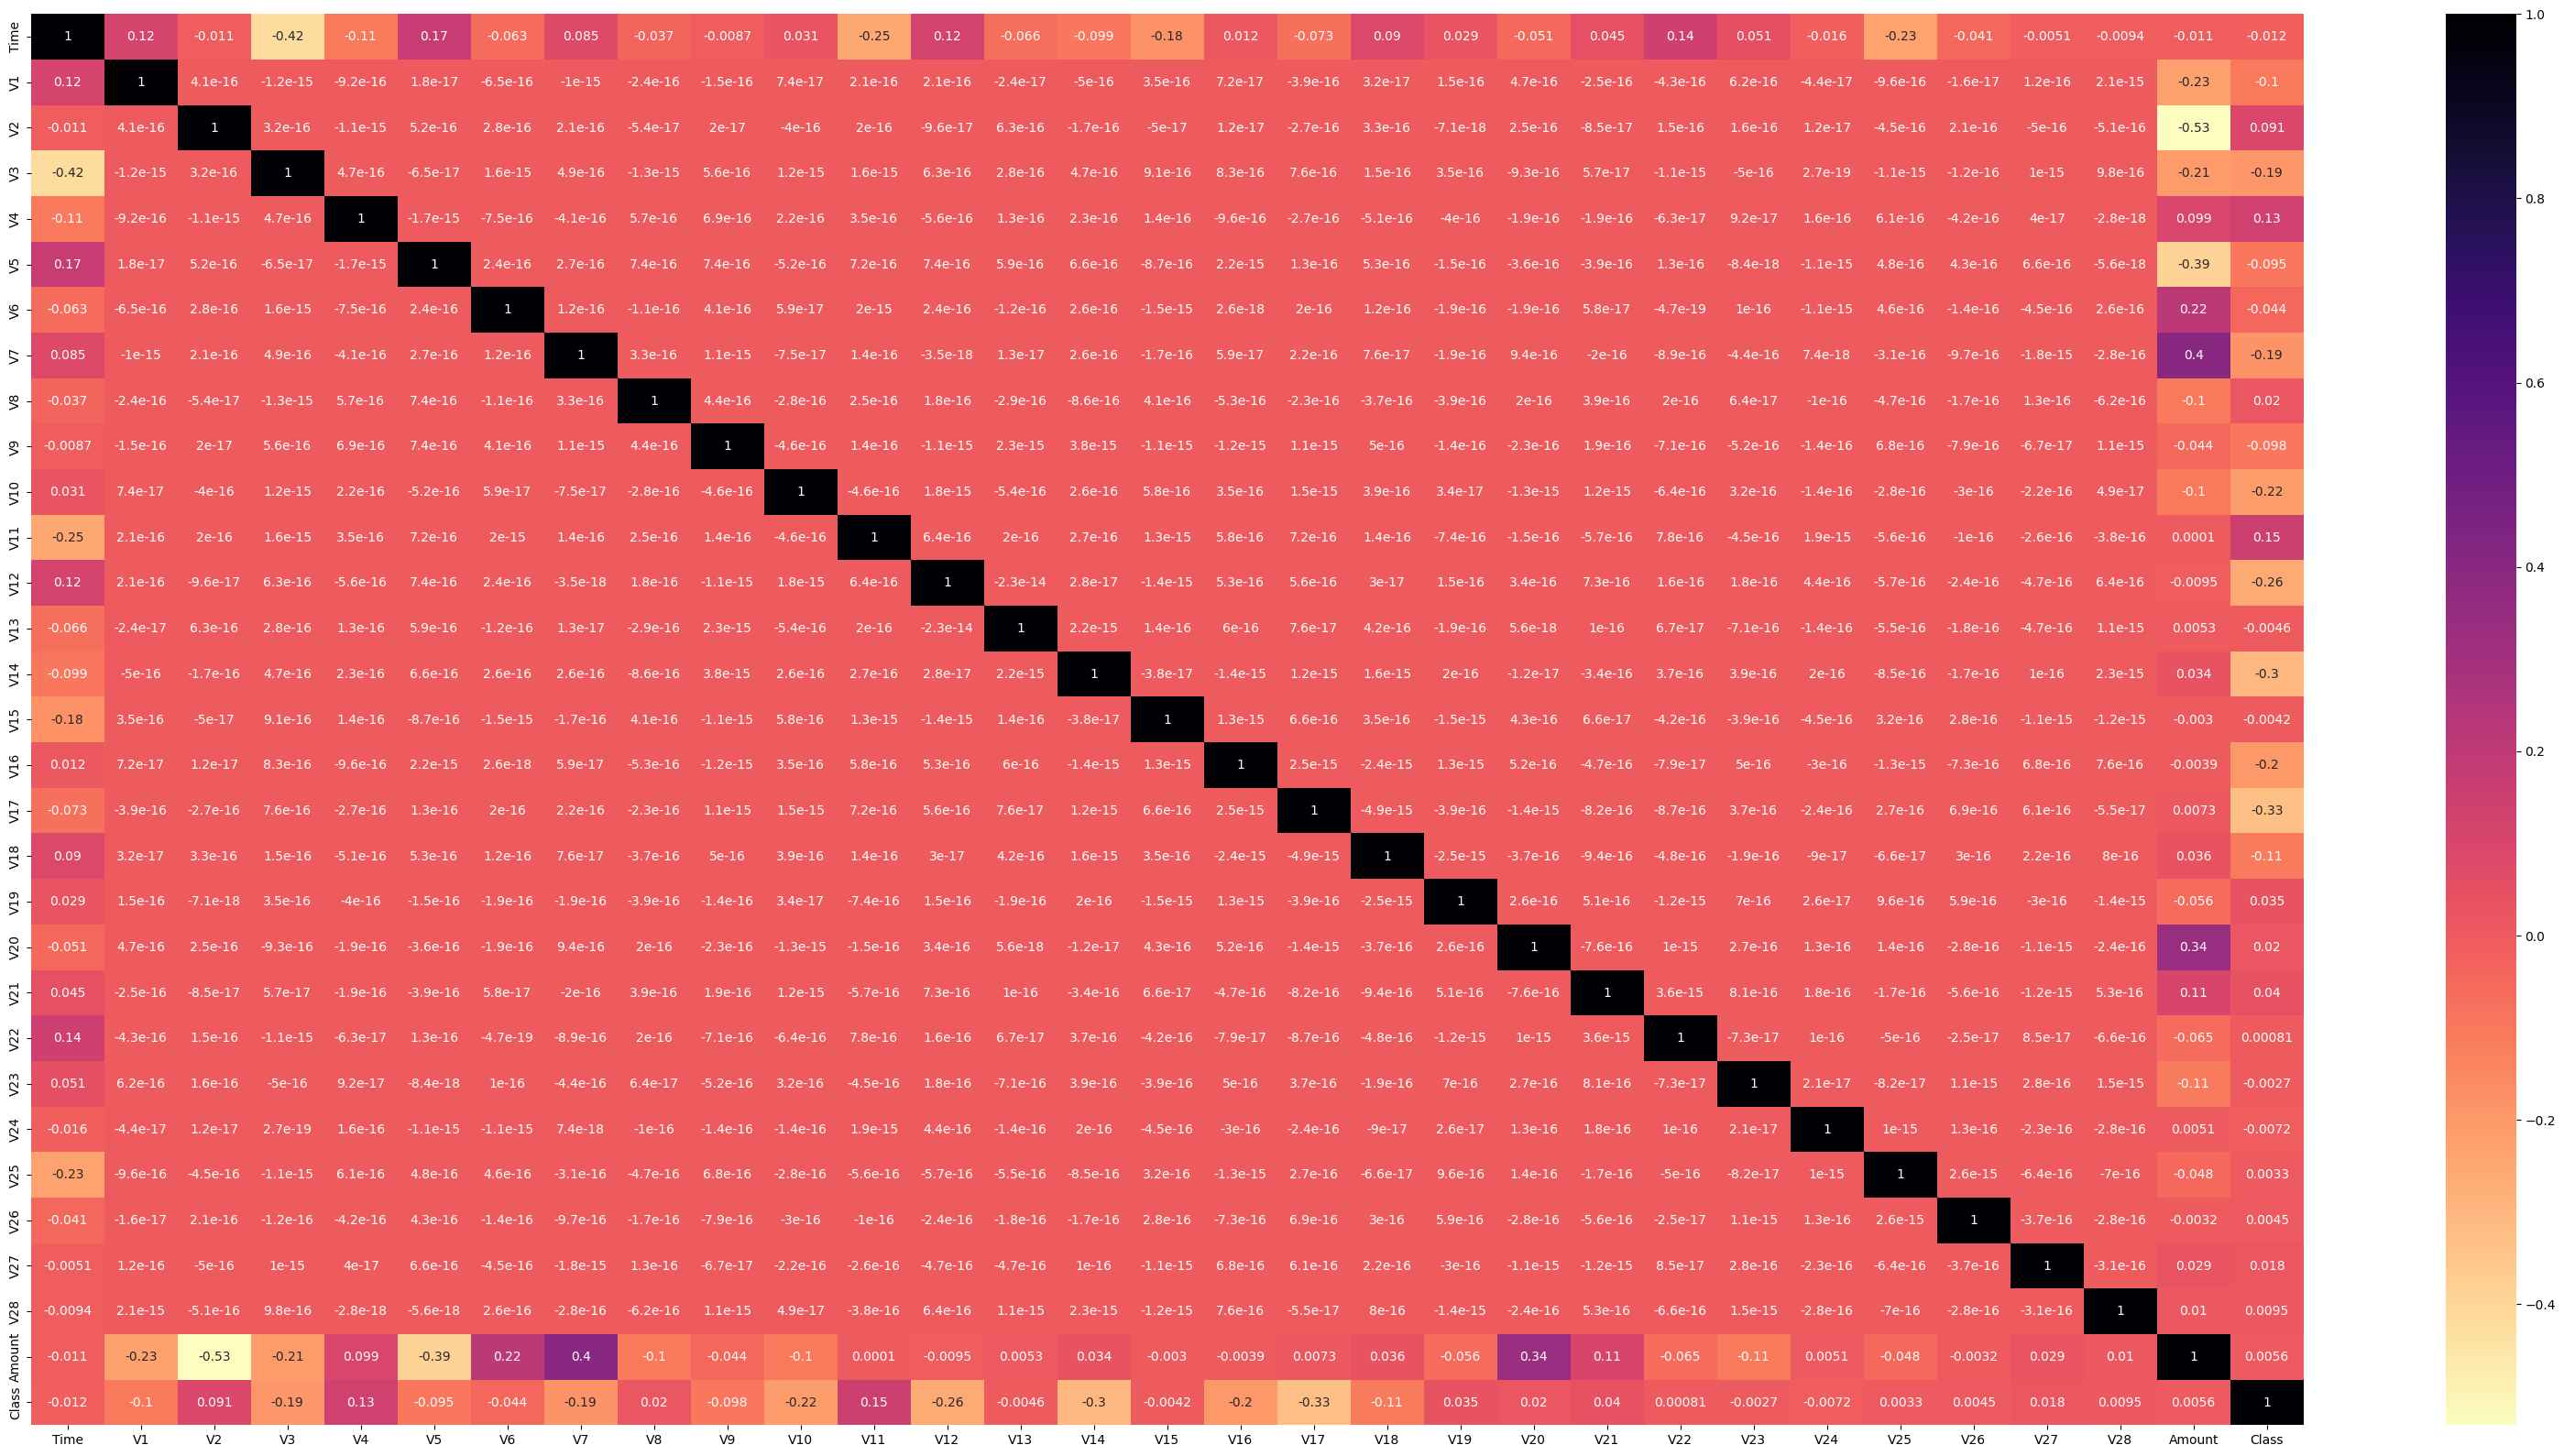

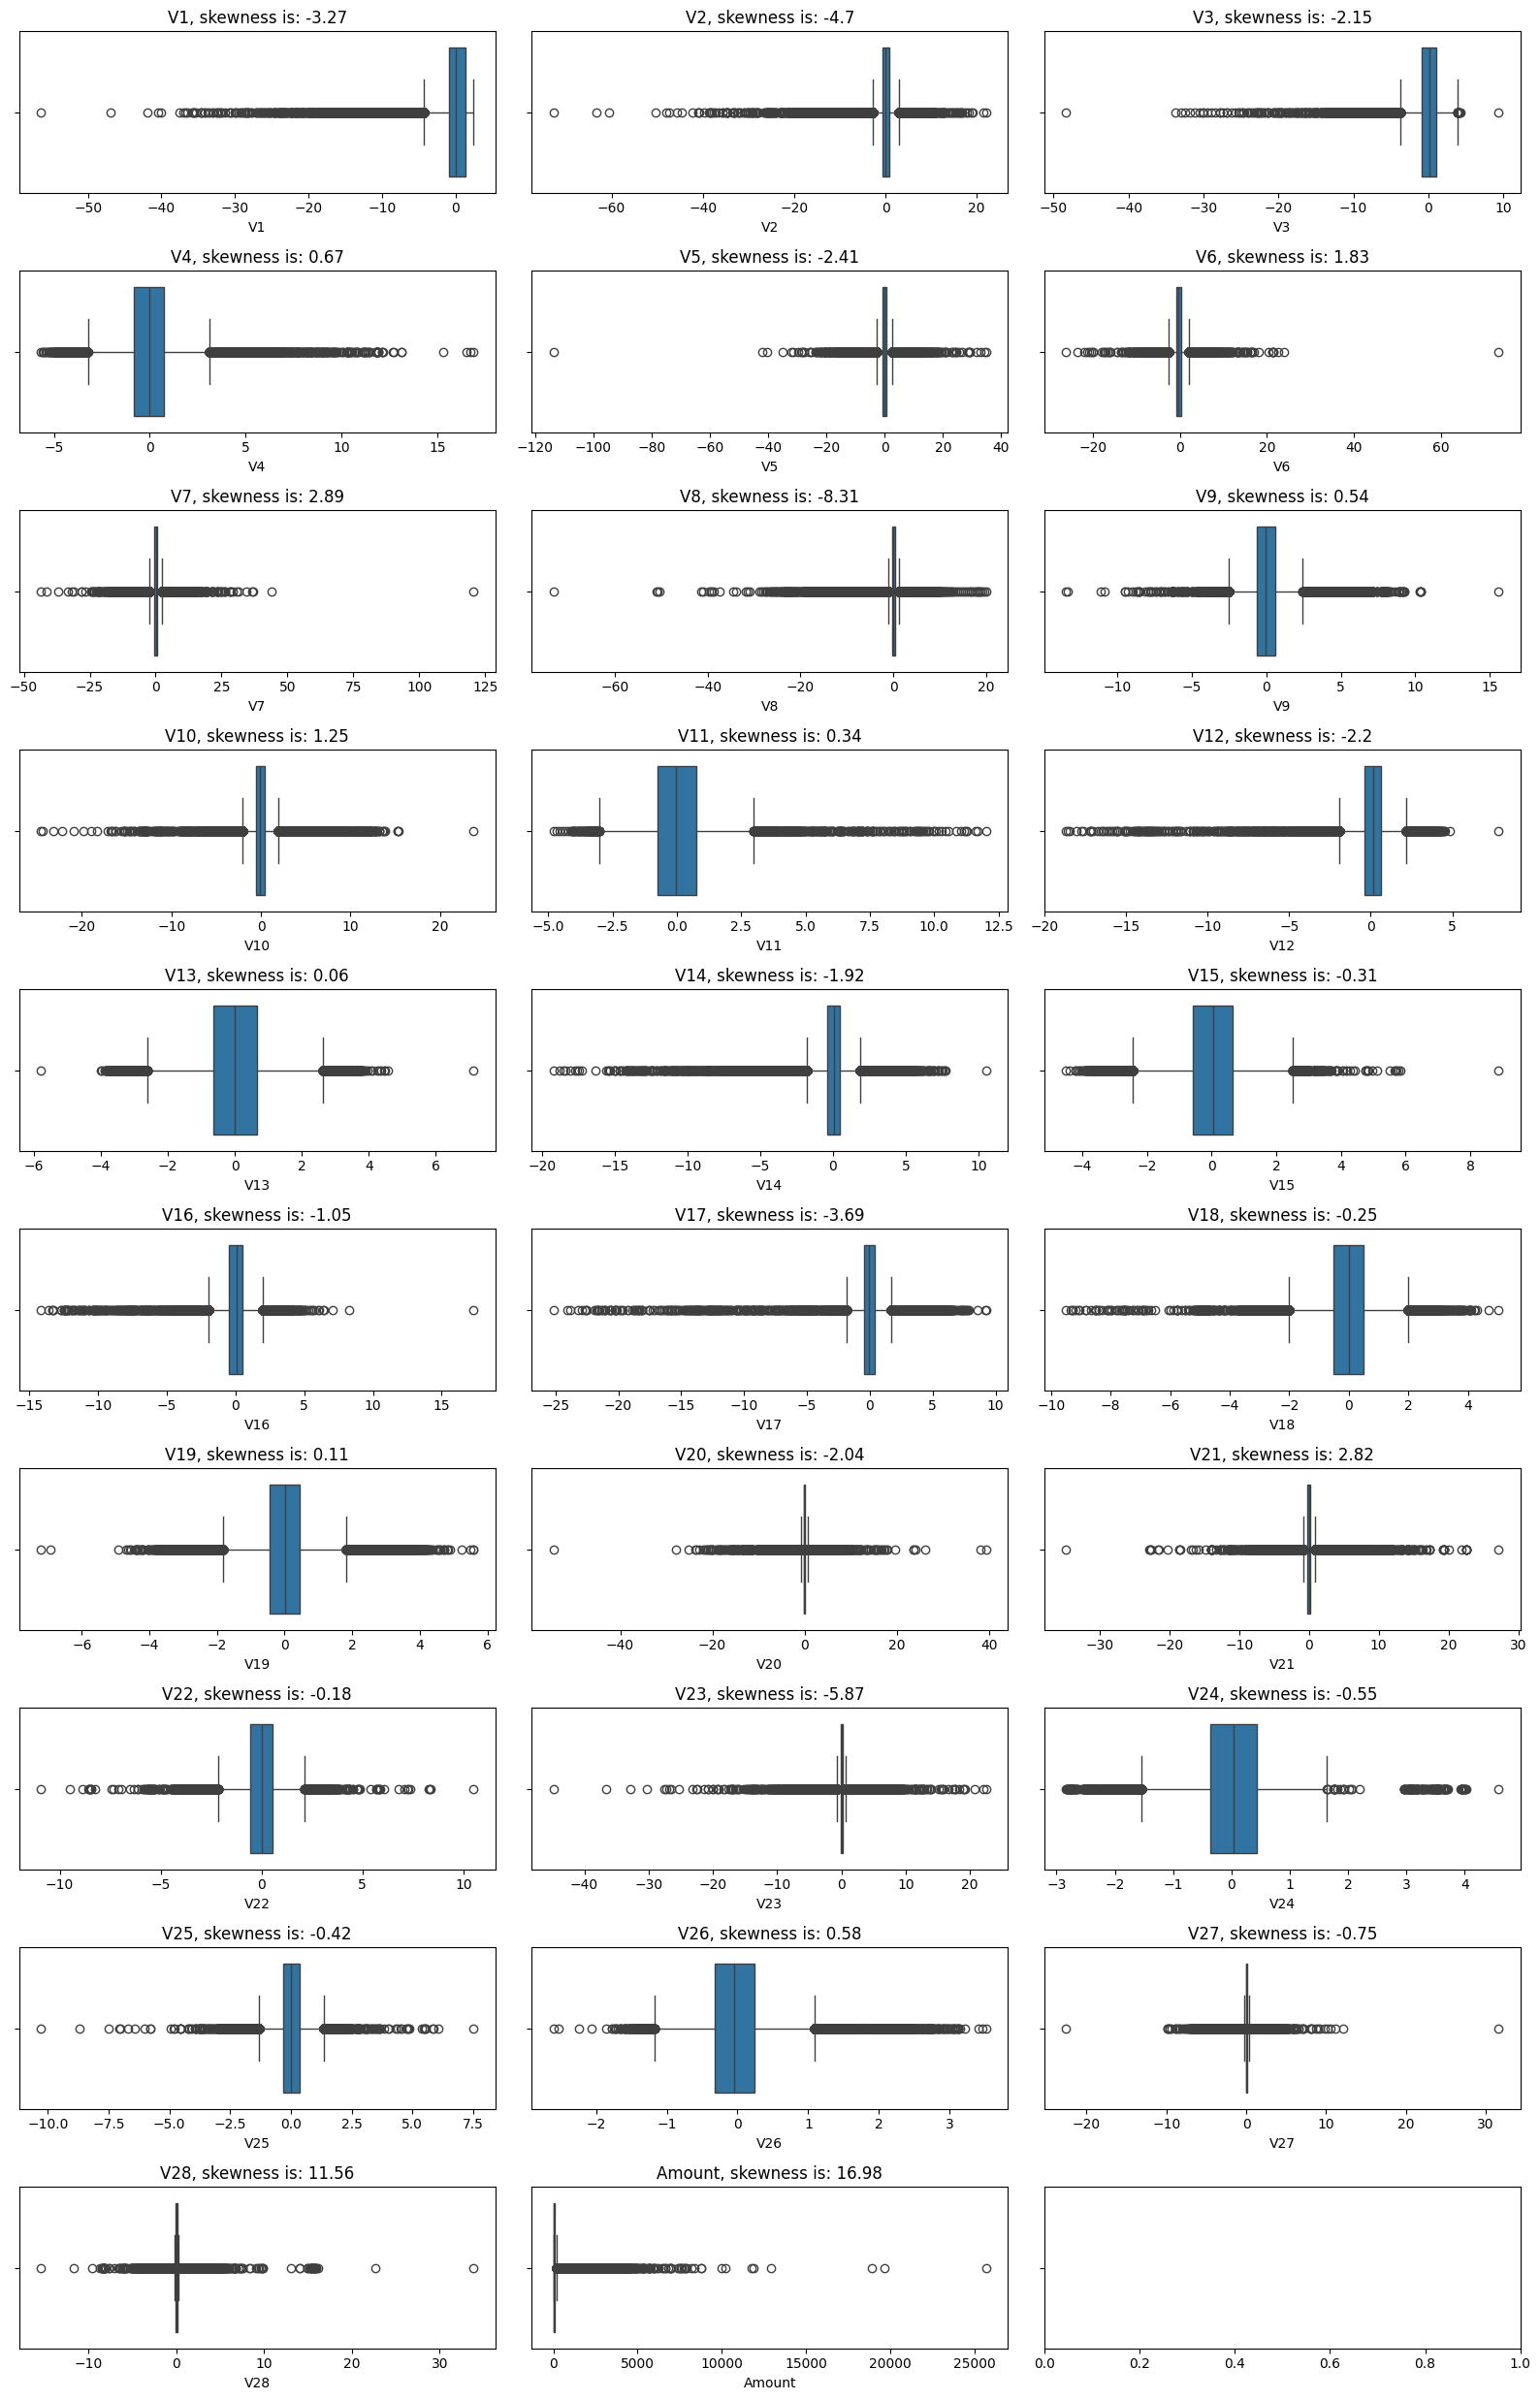

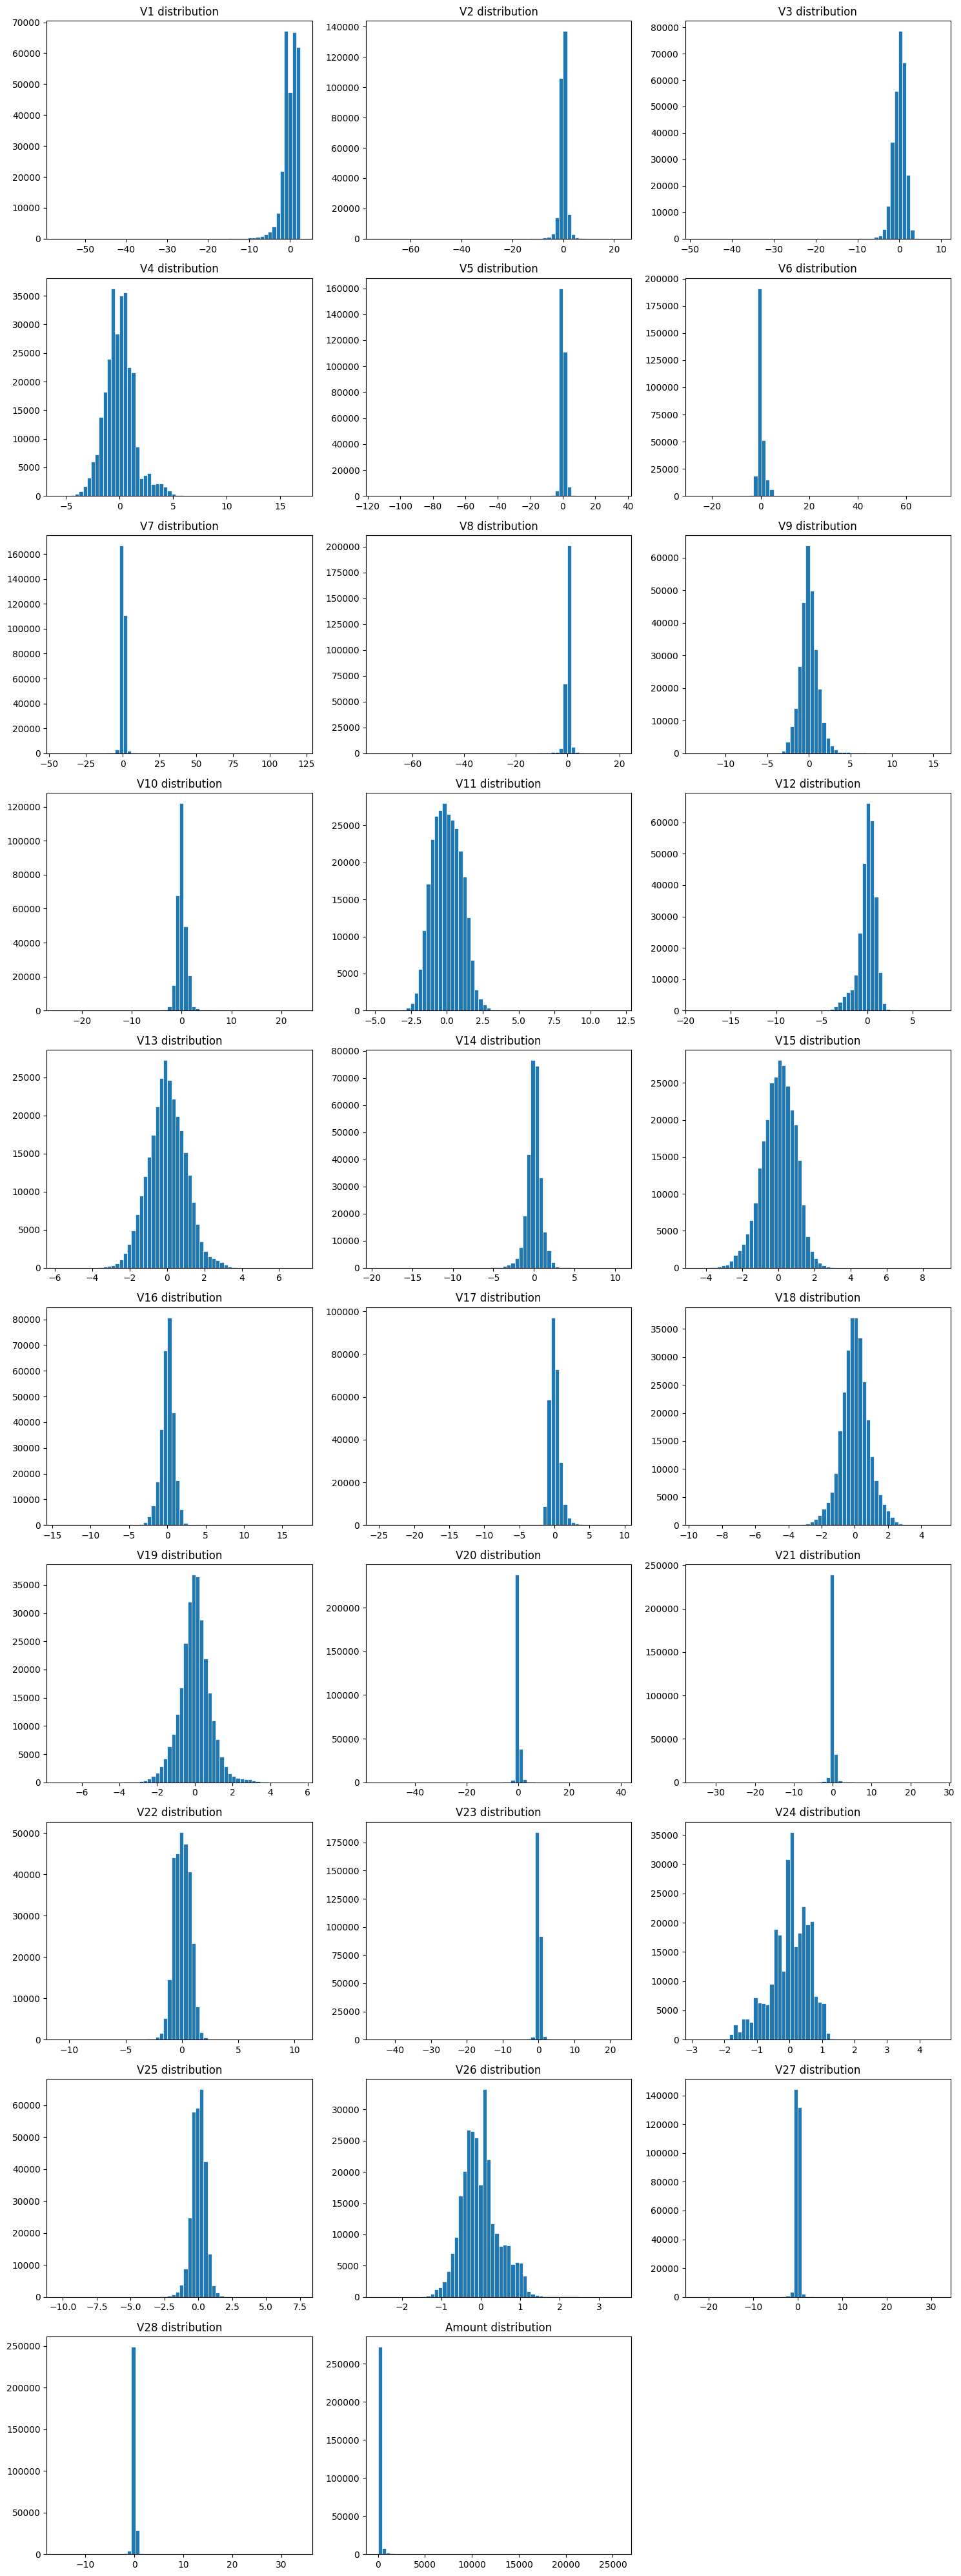

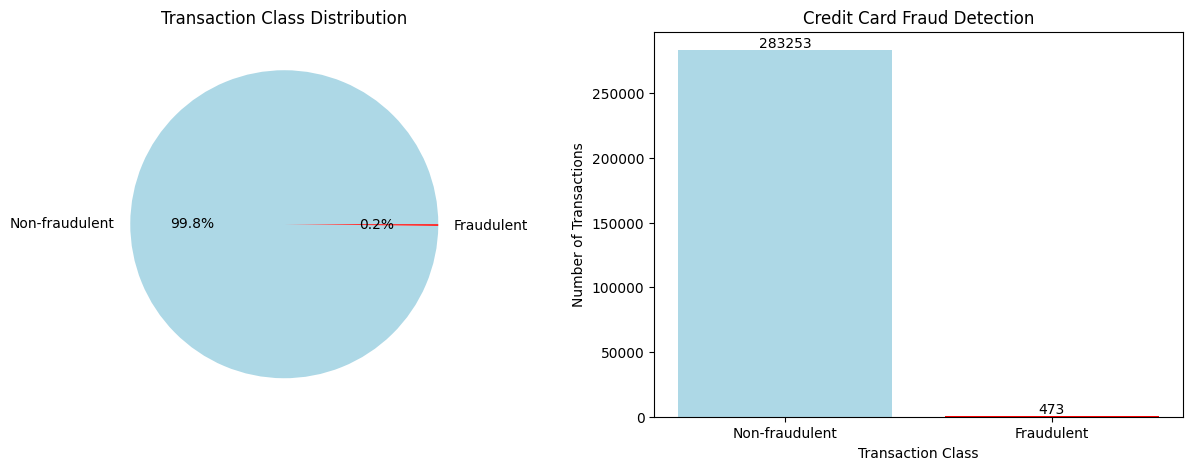

Number of normal transactions = 283253 (% 99.83328986416473)
Number of fraudulent transactions = 473 (% 0.1667101358352777)


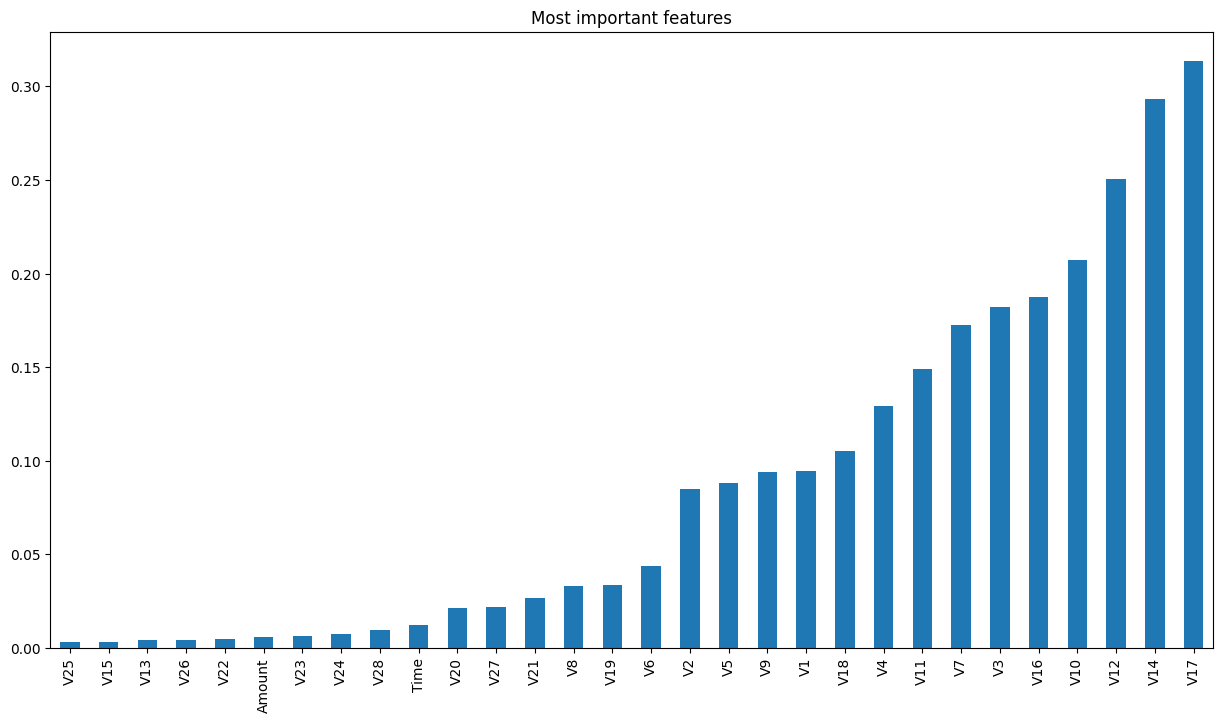

Non-Frauds: 198277 / 50.0 % of the dataset
Frauds: 198277 / 50.0 % of the dataset
[LightGBM] [Info] Number of positive: 198277, number of negative: 198277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 396554, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
***** LGBMClassifier_SMOTE DONE *****


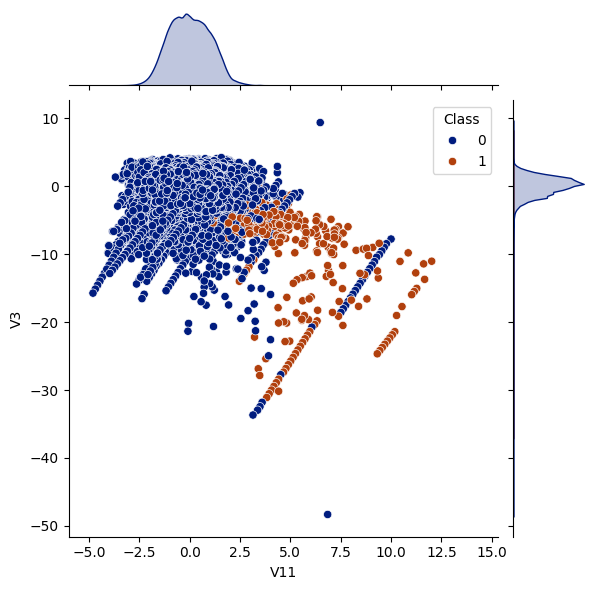

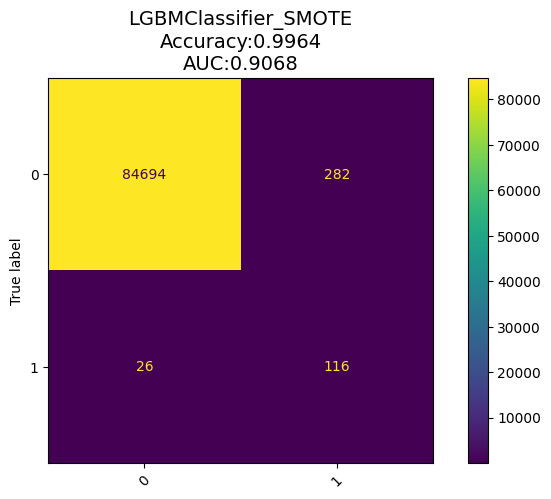

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import math
import matplotlib.pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

# for balancing dataset
from imblearn.over_sampling import SMOTE


def displayValues(y_train):
    print('Non-Frauds:', y_train.value_counts()[0], '/', round(y_train.value_counts()[0]/len(y_train) * 100,2), '% of the dataset')
    print('Frauds:', y_train.value_counts()[1], '/',round(y_train.value_counts()[1]/len(y_train) * 100,2), '% of the dataset')


def balanceWithSMOTE(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    displayValues(y_train_smote)
    
    return X_train_smote, y_train_smote


#Machine learning models

all_performances = pd.DataFrame()
list_clf_name = []
list_pred = []
list_model = []

def fit_model(model, X_train, y_train):
    X_model = model.fit(X_train,y_train)
    return X_model

def add_list(name, model, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_pred.append(y_pred)


def add_all_performances(name, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, precision, recall, f1_score, AUC]],
                         columns=["model_name","precision", "recall", "f1_score", "AUC"])
    all_performances = pd.concat([all_performances, models], ignore_index=True)  

    all_performances= all_performances.drop_duplicates()
      
    
def calculate_scores(X_train, X_test, y_train, y_test, y_pred, name, model):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    add_list(name, model, y_pred)
    add_all_performances(name, precision, recall, f1_score, AUC)
    #print(all_performances.sort_values(by=['f1_score'], ascending=False))
    

def model_performance(model, X_train, X_test, y_train, y_test, technique_name):

    name= model.__class__.__name__+"_"+technique_name
    x_model = fit_model(model, X_train, y_train)
    y_pred = x_model.predict(X_test)
    print("***** "+ name +" DONE *****")

    calculate_scores(X_train, X_test, y_train, y_test, y_pred, name, model)
    


def display_all_confusion_matrices(y_test):
    column = 2
    total_models = all_performances["model_name"].count()
    row = max(1, int(np.ceil(total_models / column)))   # row kabhi 0 nahi hoga

    f, ax = plt.subplots(row, column, figsize=(20, 5*row), sharey='row')
    ax = ax.flatten()

    for i in range(total_models):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),
                                   auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')


    for j in range(total_models, len(ax)):
        ax[j].set_visible(False)

    plt.subplots_adjust()
    f.colorbar(disp.im_)
    plt.show()



# "Importing the Dataset" 

data = pd.read_csv('/home/harshita/Harshita/hack/dataset/FraudDetectionDataset.csv')
data.head()

df = data.copy()

df.info() #We don’t have any null values

df.describe().T

def show_graphs(df):
    fraud_counts = df['Class'].value_counts()

    # pie chart
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.pie(fraud_counts, labels=['Non-fraudulent', 'Fraudulent'], colors=['lightblue', 'red'], autopct='%1.1f%%')
    ax1.set_title('Transaction Class Distribution')

    # bar plot
    ax2.bar(['Non-fraudulent', 'Fraudulent'], fraud_counts.values, color=['lightblue', 'red'])
    ax2.set_xlabel('Transaction Class')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Credit Card Fraud Detection')
    for i in ax2.containers:
        ax2.bar_label(i,)

    plt.show()

# Our dataset is quite unbalanced

show_graphs(df)

non_fradulent_count = df['Class'].value_counts()[0]
fradulent_count = df['Class'].value_counts()[1]

print(f"Number of normal transactions = {non_fradulent_count} (% {non_fradulent_count/len(df)*100})")
print(f"Number of fraudulent transactions = {fradulent_count} (% {fradulent_count/len(df)*100})")

plt.figure(figsize = (40,20))
sns.heatmap(df.corr(), cmap="magma_r", annot=True);

df.drop_duplicates(inplace=True)   #We cleaned the duplicate data

numeric_columns = (list(df.loc[:, 'V1':'Amount']))

def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle='')
plt.tight_layout()


def plot_histograms(dataset, columns, cols_per_row=3, bins=60):
    n = len(columns)
    rows = math.ceil(n / cols_per_row)
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*5, rows*4))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        axes[i].hist(dataset[col], bins=bins, linewidth=0.5, edgecolor="white")
        axes[i].set_title(f"{col} distribution")
    
    # Hide unused subplots (if any)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call function
plot_histograms(df, numeric_columns)



def find_interquartile_range(df, column_name):
    try:
        Q1 = df[column_name].quantile(0.25)  # First quartile
        Q3 = df[column_name].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range

        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
    except TypeError:
        pass
        
    return lower_limit, upper_limit

def separate_outliers(df, column_name):
    try:
        lower_limit, upper_limit = find_interquartile_range(df, column_name)
        outlier_mask_lower = df[column_name] < lower_limit
        outlier_mask_upper = df[column_name] > upper_limit
        
        if lower_limit == upper_limit == 0:
            df[column_name][outlier_mask_lower] = 0   # (?)
            df[column_name][outlier_mask_upper] = 1
        else:
            df[column_name][outlier_mask_lower] = lower_limit  
            df[column_name][outlier_mask_upper] = upper_limit
        
        # print("separate_outliers worked!")
        print("Lower limit: ", lower_limit)
        print("Upper limit: ", upper_limit)
        # print("Unique: ", df[column_name].unique())

    except:
        print("separate_outliers error!")
        pass


show_graphs(df)

non_fraudulent_count = df['Class'].value_counts()[0]
fraudulent_count = df['Class'].value_counts()[1]

print(f"Number of normal transactions = {non_fraudulent_count} (% {non_fraudulent_count/len(df)*100})")
print(f"Number of fraudulent transactions = {fraudulent_count} (% {fraudulent_count/len(df)*100})")

df["Class"].unique()

# Feature Selection

plt.figure(figsize=(15,8))
d = df.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Most important features')

plt.show()

#selected_features = (df.corr()['Class'][:-1].abs() > 0.15)
selected_features = df.corr()['Class'][:-1].abs().sort_values().tail(14)
df_selected= selected_features.to_frame().reset_index()
selected_featues = df_selected['index']


sns.jointplot(x='V11', y='V3',hue='Class', data=df, palette = 'dark')


amount = df['Amount'].values.reshape(-1, 1)

scaler = StandardScaler()
amount_scaled = scaler.fit_transform(amount)

df['Amount'] = amount_scaled

X = df[selected_featues]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 85)

### SMOTE

# SMOTE (Synthetic Minority Oversampling Technique) synthesizes samples for the minority class. 
# SMOTE works by selecting samples that are close in the feature space, drawing a line between them, 
# and generating a new sample at a point along that line.

X_train_smote, y_train_smote = balanceWithSMOTE(X_train, y_train)


# Model Building and Training

ml_models = [ lgb.LGBMClassifier()] 
             

for i in ml_models:
    model_performance(i, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")


all_performances.sort_values(by=['f1_score','AUC'], ascending=False)

# Comparison of Performances

display_all_confusion_matrices(y_test)